# Expander Dictionary Learning
In this notebook we provide experimental results pertaining to the paper XXX, in which an algorithm to solve a particular dictionary learning problem is proposed. To be clear, the problem is given a matrix $Y$ of dimension  $m \times N$, can we recover the dictionary $A$ and latent representation $X$ of the data under the model $Y = AX$? To make this problem tractable we assume the following,
- $A$ is a binary matrix of dimension $m \times n$ and is the adjacency matrix of a $k, \epsilon , d$ bipartite expander graph.
- $X$ is a sparse, real matrix whose columns are $k$ sparse (have exactly k non-zeros) and are dissociated, meaning that for any column $supp(x_i) = S$, then for any $T_1, T_2 \subset S$, $T_1 \neq T_2$, it holds that $\sum_{j \in T_1} x_{ji} \neq \sum_{j \in T_2} x_{ji} $.

In the paper linked an algorithm is proposed to solve this dictionary learning problem, up to some permutation of the columns of $A$ / rows of $X$, based on the insight that partial supports of the columns of $A$ can be identified and recovered from the columns of $Y$. This is possible due to the the unique neighbour property which $k, \epsilon , d$ bipartite expander graphs satisfy.

## Setup
### Functions for generating data
Firstly we import the libraries we will need and also define the functions we will use to generate the data for our experiments. The functions for generating and checking $A$ and $X$ are as follows,
- **generate_latent** produces a k sparse vector x with non-zeros drawn uniformly from the set $[-c_2, -c_1] \cup [c_1, c_2]$.
- **generate_exp_dictionary** returns a binary matrix which, under certain parameter regimes, is the adjacency matrix of an unbalanced fixed degree expander graph with high probability. Each column's support is chosen uniformly from random from the set of all subsets of cardinality $d$ from $[m]$. Note that the algorithms we propose can still work when $A$ is only approximatly an expander.
- **generate_exp_dictionary2** is similar to generate_exp_dictionary but generates a dictionary heuristically more likely to be the adjacency matrix of an unbalanced fixed degree expander graph. This is created by creating a random permutation of the row indicces and assigning the first d to the first column, the next set of d to the 2nd etc. Once this permutation has been used up repeat until all columns of A are constructed.
- **check_dictionary** checks that a matrix A satisfies a necessary condition for it to be the adjacency matrix of a fixed left degree $k, \epsilon, d$ bipartite expander graph. This condition ensures that no two columns overlap by at most $2\epsilon d$. Note this condition is not a sufficient condition.
- ** check_recon_A** checks the final reconstruction of A against the true A to see if there are any errors and or missing entries.
- ** check_recon_X** checks the final reconstruction of X against the true X to see if there are any errors and or missing entries. This function uses the permutation found when A is checked, so one need to runs ** check_recon_A**  first.

In [20]:
# IMPORTS
import numpy as np
import copy
import matplotlib.pyplot as plt
from timeit import default_timer as timer


# DATA GENERATION AND PERFORMANCE CHECKING FUNCTIONS
def generate_latent(n,k,c1,c2):
    b = c2-c1
    a = c1/b
    x = np.zeros(n)
    locs = np.random.permutation(n)[:k]
    x[locs] = 1
    signs = np.sign(np.random.randn(k))
    vals = b*(np.random.rand(k)+a)
    x[locs] = x[locs]*vals*signs
    return x

def generate_exp_dictionary1(m,n,d):
    A = np.zeros((m,n))
    for i in range(n):
        locs = np.random.permutation(m)[:d]
        A[locs,i] = 1
    return A

def generate_exp_dictionary2(m,n,d):
    A = np.zeros((m,n))
    alpha = int(np.floor(m/d))
    c = 0
    while c<n:
        perm = np.random.permutation(m)
        zeta = min(n-c, alpha)
        for j in range(zeta):
            locs = perm[j*d:(j+1)*d]
            A[locs,c] = 1
            c = c+1
    return A

def check_dictionary(eps,n,d,A):
    t = (1-4*eps)*d
    mu_A = np.max(np.transpose(A)@A - d*np.identity(n))
    if mu_A >= t:
        print("Generation error, A is not expander for this value of epsilon, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = False
    else:
        print("A passes coherence test, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = True
    return passed  
        
def check_recon_A(A,A_rec,d,eps,n):
    print("Checking reconstruction of A.")
    col_sum = sum(A_rec)
    print(str.format('{0:.1f}',100*len(col_sum[col_sum==d])/n), "% of columns fully formed.")
    print(str.format('{0:.1f}',100*(n - len(col_sum[col_sum==d]) - len(col_sum[col_sum==0]))/n) , "% of columns partially formed.")
    print(str.format('{0:.1f}', 100*len(col_sum[col_sum==0])/n), "% of columns have no entries.")
    overlaps = np.transpose(A_rec)@A
    A_rec_col, A_col = np.where(overlaps>(1-4*eps)*d)
    if len(col_sum[col_sum==0])<n:
        print(str.format('{0:.1f}', 100*len(A_rec_col)/(n - len(col_sum[col_sum==0]))), "% of reconstructed (fully or partially) columns match with a column in target matrix.")  
    error = 0
    missing = 0
    P = np.zeros((n,n))
    for i in range(len(A_rec_col)):
        diff = A_rec[:, A_rec_col[i]] - A[:,A_col[i]]
        error = error + sum(abs(diff[diff==1]))
        missing = missing + sum(abs(diff[diff==-1]))
        P[A_col[i], A_rec_col[i]] = 1
    print(str.format('{0:.0f}', 100*(missing+d*n-len(A_rec_col)*d)/(d*n)), "% of entries missing in total.")
    print(str.format('{0:.0f}', missing), "entries missing in matched columns.")
    print(str.format('{0:.0f}', error), "entries wrong in matched columns.")
    return P
    
def check_recon_X(X,X_rec,P,N,k):
    X_perm = P@X_rec
    print("Checking the values of X recovered.")
    tol = 10**-6
    total_entries = N*k
    total_entries_recovered = 0
    correct_loc_correct_val = 0
    correct_loc_wrong_val = 0
    wrong_loc = 0
    missing = 0
    passed = True
    for i in range(N):
        for j in range(n):
            if abs(X[j,i])>tol and abs(X_perm[j,i])>tol:
                error = abs(X[j,i] - X_perm[j,i])
                if error < tol:
                    correct_loc_correct_val +=1
                else:
                    correct_loc_wrong_val += 1
                    print("Column number = ", i, ", row number = ", j, ", true value = ", X[j,i], "value found = ", X_perm[j,i])
            elif abs(X[j,i])>tol and abs(X_perm[j,i])<tol:
                missing += 1
            elif abs(X[j,i])<tol and abs(X_perm[j,i])>tol:
                wrong_loc += 1
    print(str.format('{0:.1f}', 100*(correct_loc_correct_val/total_entries)), "% of entries correctly recovered.")
    print(str.format('{0:.1f}', 100*(correct_loc_wrong_val/total_entries)), "% of entries in correct location but have wrong value for location.")
    print(str.format('{0:.1f}', 100*(missing/total_entries)), "% of entries missing.")
    return X_perm
    

### Auxillary functions
As previously stated, we exploit the unique neighbour property of expander graphs to extract partial supports of the columns of $A$ and then cluster these partial supports to reconstruct each column. The following 'auxillary' encapsulate this idea.
- **xps** extracts all partial supports of columns of $A$ from $y$. It returns both the partial supports in $W$ as well as the value of the coefficients in $vals$.
For experiment 1, the demonstration of $A$ can be reconstructed from partial supports extracted from the columns of $Y$ there are the following two auxillary functions.
- **extract_supports** is used in experiment 1, this function process a data point by first extracting any partial supports, then matches these partial supports to a dictionary element before finally updating said dictionary elements.
- **update_column** updates the reconstruction of a column with the information gathered from a partial support of that column.
For experiment 2, recovering $A$ and $X$ from $Y$, we have the following three auxillary functions.
- **process_column** takes a column of $Y$, extracts partial supports and returns them along with the column index of $A$ which the partial support matches to, the index the column (data id), the value or coefficient of the partial measurement and finally whether or not the partial support matches with an already partially reconstructed column of $A$. 
- **sort_unmatched_columns** takes the partial supports extracted from all columns of $Y$ that do not match with a partially reconstructed column of A and clusters them.
- **update_reconstruction** takes all the partial supports extracted during an epoch and uses them to update the reconstruction of $A$ and $X$.

In [21]:
# USED IN BOTH EXPERIMENTS 1 and 2
def xps(y,m,eps,d,k):
    tol1 = 10**-8
    tol2 = 10**-8
    y_copy = copy.deepcopy(y) 
    t = (1-2*eps)*d
    z1 = len(y_copy);
    z2 = int(z1 - np.ceil(t) +1);
    W = np.zeros((m,k))
    vals = np.zeros(k)
    q = 0
    for i in range(z2):
        if np.abs(y_copy[i])> tol1:
            locs = list()
            locs.append(i)
            for j in range(i+1, m):
                if np.abs(y_copy[j] - y_copy[i]) < tol2:
                    locs.append(j)
                    y_copy[j] = 0
            if len(locs)>t:
                W[locs,q] = 1
                vals[q] = y_copy[i]
                q = q+1
        y_copy[i] = 0
    W = W[:,:q]
    vals = vals[:q]
    return [W, vals, q]


# AUXILLARY FUNCTIONS USED IN EXPERIMENT 1: DEMONSTRATING HOW SUPPORTS OF A CAN BE EXTRACTED FROM Y
def extract_supports(y, A_rec, m, eps, d, k, c, per):
    tau = (1-4*eps)*d
    [W, vals, q] = xps(y,m,eps,d,k)   
    if q > 0:
        if c == 0:
            A_rec[:,:q] = W
            c = q
        else:
            matches = np.transpose(W)@A_rec[:,:c]
            matches[matches<=tau] = 0
            matches[matches>tau] = 1
            num_matches = matches.sum(axis=1)
            col_ind = matches@np.arange(c)           
            for i in range(q):
                if num_matches[i] == 0:
                    if c<n:
                        old = sum(A_rec[:,c])
                        A_rec[:,c]=update_column(A_rec[:,c],W[:,i])
                        per = per + sum(A_rec[:,c]) - old
                        c=c+1
                    else:
                        print("Error in extract_supports: trying to add new column which exceeds total number of columns")                    
                elif num_matches[i] == 1:
                    z = int(col_ind[i])
                    old = sum(A_rec[:,z])
                    A_rec[:,z]=update_column(A_rec[:,z],W[:,i])
                    per = per + sum(A_rec[:,z]) - old
                elif num_matches[i] > 1:
                    print("Error in extract_supports: partial support matches with ", num_matches," partially reconstructed columns of A.")
#     else:
# #         print("Error in extract_supports: xps returned no partial supports for this data point.")
    return [A_rec, c, per]

def update_column(a,w):
    a = a+w
    a[a>0] = 1
    return a

# AUXILLARY FUNCTION USED IN EXPERIMENT 2: RECOVERING A AND X FROM Y
def process_column(y, A_rec, m, eps, d, k, c, dpid):
    exit_flag = True
    tau = (1-4*eps)*d
    [W, vals, q] = xps(y,m,eps,d,k)   
    if q > 0:
        match_check = np.zeros(q) 
        match_col_id = -0.5*np.ones(q)
        data_id = dpid*np.ones(q)          
        if c > 0:           
            matches = np.transpose(W)@A_rec
            matches[matches<=tau] = 0
            matches[matches>tau] = 1
            num_matches = matches.sum(axis=1)
            col_ind = matches@np.arange(c)           
            for i in range(q):
                if num_matches[i] == 0:
                    if c>=n:
                        print("Error: trying to add new column which exceeds total number of columns")
                        exit_flag==False
                elif num_matches[i] == 1:
                    match_check[i] = 1                   
                    z = int(col_ind[i])
                    match_col_id[i] = z
                elif num_matches[i] > 1:
                    print("Error: partial support matches with ", num_matches," partially reconstructed columns of A.")
                    exit_flag = False
    else:
        exit_flag = False
        match_check = []
        match_col_id = []
        data_id = []
    return [W, match_check, match_col_id, data_id, vals, exit_flag]

def sort_unmatched_columns(W, eps, d, c): 
    q = W.shape[1]
    col_id_new = -0.5*np.zeros(q)
    tau = (1-4*eps)*d
    matches = np.transpose(W)@W
    matches[matches<=tau] = 0
    matches[matches>tau] = 1
    i =0
    while i<q:
        if sum(matches[:,i]) > 0:
            temp = np.where(matches[:,i]==1)[0]
            col_id_new[temp] = c
            c +=1
            for j in range(len(temp)):
                matches[temp[j],:] = np.zeros(q)
                matches[:,temp[j]] = np.zeros(q)
        i +=1
    return [col_id_new, c]

def update_reconstruction(W, col_id, data_id, vals, A_rec, X_rec):
    for i in range(len(col_id)):
        A_rec[:, int(col_id[i])] += W[:,i]
        X_rec[int(col_id[i]), int(data_id[i])] = vals[i]
    A_rec[A_rec>0] = 1
    return [A_rec, X_rec]



# Experiments
### Generating a valid dictionary
We firstly generate a dictionary to use in the following experiments. Note that the algorithm can succeed in recovering $A$ even if $A$ is not truly the bipartite of an expander graph. However if A is not an expander it is not guaranteed that the algorithm will recover X, due to the fact that the unique neighbour property may not hold. This means that columns of $Y$, or the residue of $Y$, $R = Y - A_{rec} X_{rec}$, may not have any partial supports that can extracted since the respective columns of $A$ are to overlapping. Checking that $A$ is indeed an expander graph is NP hard since one is required to check that all $\binom{n}{k}$ subsets of the columns satisfy the unique neighbour property. Hence we do not know the true value of $\epsilon$! 

In [65]:
# Dictionary parameters parameters
#n = 1200;
#m = int(np.ceil(4*n/5));
#d = 9;
#eps = 1/6;
#N = 500

n = 5000;
m = int(np.ceil(4*n/5));
d = 10;
eps = 1/6;
N = 500

# Generate a dictioary and check that passes necessary test.
num_generations = 0
passed = False
while passed==False and num_generations < 100:
    A = generate_exp_dictionary1(m,n,d);
    passed = check_dictionary(eps,n,d,A)
    num_generations += 0
if passed == True:
    print("Generated dictionary that passes the coherency test")
else:
    print("Failed to generate dictionary that passes the coherency test, consider different parameters")

A passes coherence test, mu_A =  3.00 , tau =  3.33 .
Generated dictionary that passes the coherency test


## Dictionary Statistics

In [66]:
row_count = np.sum(A, 1)
print(A.shape)
print(sum(sum(A)))
print(min(row_count))
print(max(row_count))
print(np.mean(row_count))
print(n*d/m)

(4000, 5000)
50000.0
2.0
27.0
12.5
12.5


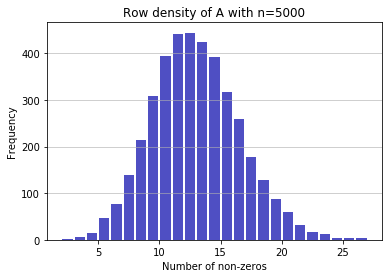

In [67]:
num_bins = int(max(row_count) - min(row_count))

freq, bins, patches = plt.hist(row_count, bins=num_bins, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of non-zeros')
plt.ylabel('Frequency')
plt.title('Row density of A with n=%s'%(n))
maxfreq = freq.max()

(4000, 5000)
50369


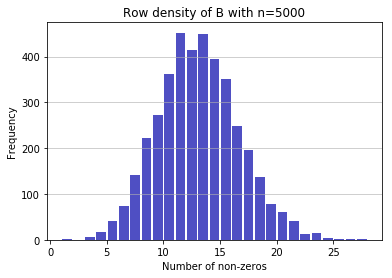

In [69]:
# FOR COMPARISON AGAINST IID BERNOULLI ENTRIES
B = np.random.binomial(1, d/m, size=(m,n))
print(B.shape)
print(sum(sum(B)))
row_count_B = np.sum(B, 1)
num_bins_B = int(max(row_count_B) - min(row_count_B))

freq, bins, patches = plt.hist(row_count_B, bins=num_bins_B, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of non-zeros')
plt.ylabel('Frequency')
plt.title('Row density of B with n=%s'%(n))
maxfreq = freq.max()

## Experiment 1 - Demonstrating extraction of partial supports
In this experiment we demonstrate how we can extract partial supports to reconstruct the columns of A. In this experiment the algorithm is presented with a stream of columns of $Y$, which one could think of as a stream of data points, the objective being to reconstruct $A$ using the minimum number of data points. Hence for a fixed dictionary $A$, we sequentially generate latent representations of the data (i.e., columns the in X) with a given sparsity, generate a data point (column of $Y$), pass this to the algorithm and record the total number of entries of $A$ that have been recovered.

Note that as already stated the it is NP hard to check that $A$ is an expander, regardless the algorithm can still succeed in recovering $A$ so long as enough submatrices satisfy the unique neighbour property condition. This does mean however that some data points may not return any partial supports, this is increasingly likely for larger $k$.

In [121]:
b1=1;
b2=5;
k = [int(np.ceil(0.02*n)), int(np.ceil(0.04*n)), int(np.ceil(0.06*n))]
limit = N

if passed == True:
    per1=np.zeros((len(k), limit));
    comp_time1 = np.zeros((len(k), limit))
    done = False
    for j in range(len(k)):
        print("Solving problem with k/n=", str.format('{0:.2f}', 100*k[j]/n),"%.")
        A_rec1 = np.zeros((m,n))
        c1=0
        entry_total1 = 0
        total_comp_time1 = 0
        N=0
        while done == False and N < limit:
            x = generate_latent(n,k[j],b1,b2)
            y = A@x
            if done == False:
                start_time = timer()
                [A_rec1, c1, entry_total1] = extract_supports(y, A_rec1, m, eps, d, k[j], c1, entry_total1)
                end_time = timer()
                total_comp_time1 = total_comp_time1 + (end_time - start_time)
                comp_time1[j,N] = total_comp_time1
                per1[j, N] = entry_total1
                if entry_total1 >= n*d:
                    comp_time1 = comp_time1[:N+1]
                    per1[j, (N+1):limit] = n*d*np.ones(limit - N - 1)
                    done = True
                    print("Finished reconstructing the dictionary.")
            N = N + 1
            if np.mod(N, limit/10)==0:
                print(str.format('{0:.2f}', 100*N/limit), "% of max data points processed.")
            if N == limit:
                print("Max number of data points reached, checking reconstruction...")
        print("Finished attempts to solve reconstruction problem with k/n =",str.format('{0:.2f}', 100*k[j]/n),"%%.")
        print("Checking reconstruction of A with k/n=", str.format('{0:.2f}', 100*k[j]/n),"%.")
        P = check_recon_A(A,A_rec1,d,eps,n)

Solving problem with k/n= 2.00 %.
10.00 % of max data points processed.
20.00 % of max data points processed.
30.00 % of max data points processed.
40.00 % of max data points processed.
50.00 % of max data points processed.
60.00 % of max data points processed.
70.00 % of max data points processed.
80.00 % of max data points processed.
90.00 % of max data points processed.
100.00 % of max data points processed.
Max number of data points reached, checking reconstruction...
Finished attempts to solve reconstruction problem with k/n = 2.00 %%.
Checking reconstruction of A with k/n= 2.00 %.
Checking reconstruction of A.
98.4 % of columns fully formed.
1.4 % of columns partially formed.
0.2 % of columns have no entries.
100.0 % of reconstructed (fully or partially) columns match with a column in target matrix.
0 % of entries missing in total.
23 entries missing in matched columns.
0 entries wrong in matched columns.
Solving problem with k/n= 4.00 %.
10.00 % of max data points processed.
20.

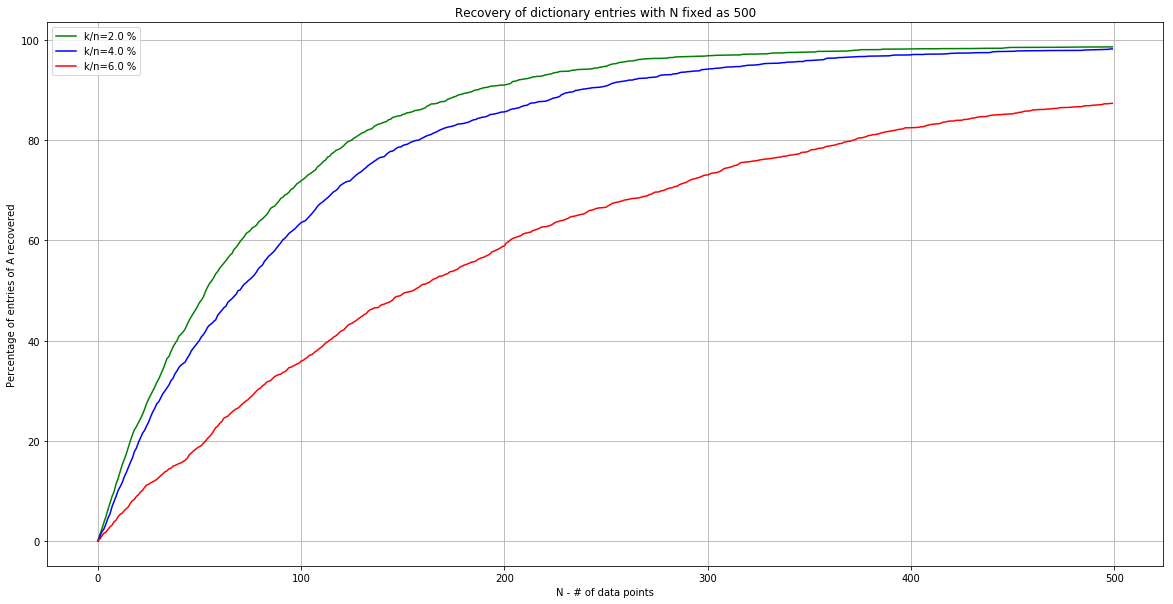

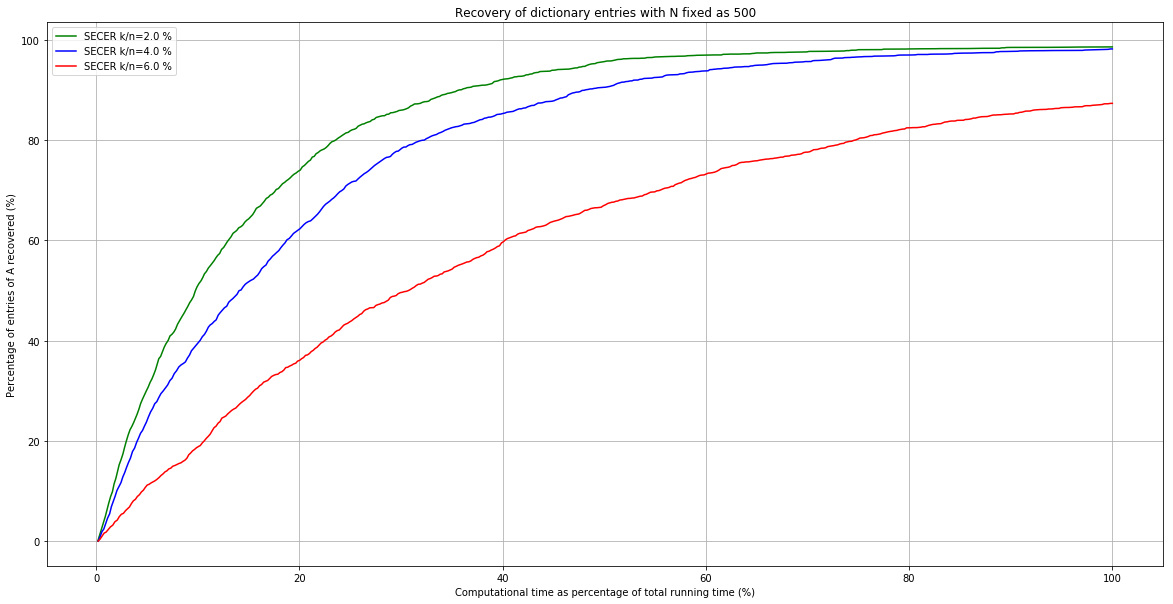

In [126]:
# Plots
plot_per1 = 100*per1/(d*n)
rel_comp_time1 = comp_time1

for j in range (len(k)):
    rel_comp_time1[j,:] = 100*rel_comp_time1[j,:]/comp_time1[j, N-1]

plt.figure(1)
plt.figure(figsize=(20,10))
plt.plot(range(N), plot_per1[0], 'g', label="k/n=%s %%"%(100*k[0]/n))
plt.plot(range(N), plot_per1[1], 'b', label="k/n=%s %%"%(100*k[1]/n))
plt.plot(range(N), plot_per1[2], 'r', label="k/n=%s %%"%(100*k[2]/n))
plt.grid(True)
plt.title('Recovery of dictionary entries with N fixed as %s'%(N))
plt.xlabel('N - # of data points')
plt.ylabel('Percentage of entries of A recovered')
plt.legend()
plt.savefig('./figures/recovery_curve_N.eps', format='eps', bbox_inches='tight')

plt.figure(2)
plt.figure(figsize=(20,10))
plt.plot(rel_comp_time1[0], plot_per1[0], 'g', label="SECER k/n=%s %%"%(100*k[0]/n))
plt.plot(rel_comp_time1[1], plot_per1[1], 'b', label="SECER k/n=%s %%"%(100*k[1]/n))
plt.plot(rel_comp_time1[2], plot_per1[2], 'r', label="SECER k/n=%s %%"%(100*k[2]/n))
plt.grid(True)
plt.title('Recovery of dictionary entries with N fixed as %s'%(N))
plt.xlabel('Computational time as percentage of total running time (%)')
plt.ylabel('Percentage of entries of A recovered (%)')
plt.legend()
plt.savefig('./figures/recovery_curve_time.eps', format='eps', bbox_inches='tight')

### Remarks
As the ratio of $k/n$ is increased the rate at which the algorithm is able to extract partial supports and hence 'learn' $A$ decreases. This is inline with our intuition since a larger $k$ means that more columns are being added together to form a column of $Y$, thereby incurring a higher risk of overlap and hence occlusion of entries from potential partial supports.

Secondly in terms of computational running time the rate at which entries of $A$ are recovered is logarithmic in the number of data points. This also agrees with our intuition since the rate at which we observe partial supports for new or only partially completed should be akin to the waiting time for a coupon collector problem.

## Experiment 2 - recovering $A$ and $X$ from $Y$
In this experiment the challenge is, given a block of data $Y$, to recover $A$ and $X$ under the assumptions previously stated. We now demonstrate that this can be achieved by iteratively passing through the data sequentially or indeed in a parallelised fashion, each time extracting partial supports, updating the reconstructions of $A$ and $X$ and before updating the residual $R=Y - A_{rec}X_{rec}$ and then repeating. Algorithm proceeds until one of the following three conditions has been met,<br>
1) Both $A$ and $X$ have been recovered.<br>
2) The algorithm stops making progress (implying that $A$ is not an expander and/or $N$ is too small).<br>
3) The maximum number of allowed epochs (computational budget) has been reached.<br>

In [123]:
# GENERATE LATENET REPRESENTATION
#N = 500
b1=1;
b2=5;
#k = [int(np.ceil(0.02*n))]#, int(np.ceil(0.05*n))]
X = np.zeros((len(k), n, N))
for j in range(len(k)):
    for i in range(N):
        X[j,:,i] = generate_latent(n,k[j],b1,b2)

In [124]:
# LEARN DICTIONARY
max_epoch = 40
tol = 10**-8
X_sparsity = np.zeros(len(k))
total_sparsity = np.zeros(len(k))
Y_frob = np.zeros(len(k))
comp_time = np.zeros(len(k))

number_k_to_process = len(k)

if passed == True:
    A_sparsity = np.count_nonzero(A)
    A_rec = np.zeros((len(k),m,n))
    X_rec = np.zeros((len(k),n,N))
    frob_error_series = np.ones((len(k), max_epoch))
    A_entries = np.zeros((len(k), max_epoch))
    X_entries = np.zeros((len(k), max_epoch))
    total_entries = np.zeros((len(k), max_epoch))
    for j in range(number_k_to_process):
        print("Solving dictionary learning problem with k/n = ", str.format('{0:.1f}', 100*k[j]/n), '%, N = ', str.format('{0:.0f}', N))
        X_sparsity[j] = k[j]*N
        total_sparsity[j] = A_sparsity + X_sparsity[j]
        Y = A@X[j]
        R = copy.deepcopy(Y)
        Y_frob[j] = np.sqrt(sum(sum(Y**2)))
        num_entries = 0
        epoch = 0
        c=0
        exit_program = False
        frob_error = Y_frob[j]
        start_time = timer()
        while epoch < max_epoch and frob_error > tol and exit_program==False:            
            # Serial case so use a for loop to iterate through the data.
            num_matched = 0
            num_new = 0    
            for i in range(N):
                [W, match_check, match_col_id, data_id, vals, supports_found]=process_column(R[:,i], A_rec[j,:,:c], m, eps, d, k[j], c, i)
                matches = np.where(match_check==1)[0]
                new = np.where(match_check==0)[0]
                if supports_found == True:
                    if len(matches)>0:
                        if num_matched > 0:
                            W_match = np.concatenate((W_match, W[:,matches]), axis=1)
                            col_id_match = np.concatenate((col_id_match, match_col_id[matches]), axis=0)
                            data_id_match = np.concatenate((data_id_match, data_id[matches]), axis=0)
                            val_match = np.concatenate((val_match, vals[matches]), axis=0)
                        else:
                            W_match = W[:,matches]
                            col_id_match = match_col_id[matches]
                            data_id_match = data_id[matches]
                            val_match = vals[matches]
                            num_matched += W_match.shape[1]

                    if len(new)>0:
                        if num_new > 0:
                            W_new = np.concatenate((W_new, W[:,new]), axis=1)
                            data_id_new = np.concatenate((data_id_new, data_id[new]), axis=0)
                            val_new = np.concatenate((val_new, vals[new]), axis=0)
                        else:
                            W_new = W[:,new]
                            data_id_new = data_id[new]
                            val_new = vals[new]
                            num_new += W_new.shape[1]

            if num_matched > 0 and num_new > 0:
                [col_id_new, c] = sort_unmatched_columns(W_new, eps, d, c)       
                W_all = np.concatenate((W_match, W_new), axis=1)
                col_id_all = np.concatenate((col_id_match, col_id_new), axis=0)
                data_id_all = np.concatenate((data_id_match, data_id_new), axis=0)
                val_all = np.concatenate((val_match, val_new), axis=0)          
            elif num_matched > 0 and num_new == 0:
                W_all = W_match
                col_id_all = col_id_match
                data_id_all = data_id_match
                val_all = val_match     
            elif num_matched == 0 and num_new > 0:
                [col_id_all, c] = sort_unmatched_columns(W_new, eps, d, c)
                W_all = W_new
                data_id_all = data_id_new
                val_all = val_new                       
            elif num_matched == 0 and num_new == 0:
                print("No partial supports recovered, terminating algorithm")
                frob_error_series[j, epoch:] = frob_error
                A_entries[j,epoch:] = A_entries[j,epoch-1]
                X_entries[j,epoch:] = X_entries[j,epoch-1]
                total_entries[j, epoch:] = total_entries[j, epoch-1]
                exit_program = True

            if exit_program == False:
                [A_rec[j], X_rec[j]] = update_reconstruction(W_all, col_id_all, data_id_all, val_all, A_rec[j], X_rec[j])
                R = Y - A_rec[j]@X_rec[j]
                frob_error = np.sqrt(sum(sum(R**2)))
                frob_error_series[j, epoch] = frob_error
                A_entries[j,epoch] = np.count_nonzero(A_rec[j])
                X_entries[j,epoch] = np.count_nonzero(X_rec[j])
                total_entries[j, epoch] = A_entries[j,epoch] + X_entries[j,epoch]
                epoch +=1    
                print('Epoch ', str.format('{0:.0f}', epoch), " processed, l_2 error = ", str.format('{0:.1f}', 100*frob_error/Y_frob[j]), '%, l_0 error =', str.format('{0:.1f}', 100*(total_sparsity[j] - total_entries[j,epoch-1])/total_sparsity[j]), "%.")
                if epoch == max_epoch:
                    print("Maximum number of epochs reached.")
            end_time = timer()
            comp_time[j] = end_time - start_time
        print("")
        P = check_recon_A(A,A_rec[j],d,eps,n)
        print("")
        check_recon_X(X[j],X_rec[j],P,N,k[j])
        print("")


Solving dictionary learning problem with k/n =  2.0 %, N =  500
Epoch  1  processed, l_2 error =  50.3 %, l_0 error = 13.3 %.
Epoch  2  processed, l_2 error =  24.8 %, l_0 error = 3.2 %.
Epoch  3  processed, l_2 error =  12.9 %, l_0 error = 0.8 %.
Epoch  4  processed, l_2 error =  7.9 %, l_0 error = 0.3 %.
Epoch  5  processed, l_2 error =  5.8 %, l_0 error = 0.2 %.
Epoch  6  processed, l_2 error =  5.3 %, l_0 error = 0.1 %.
Epoch  7  processed, l_2 error =  5.0 %, l_0 error = 0.1 %.
No partial supports recovered, terminating algorithm

Checking reconstruction of A.
100.0 % of columns fully formed.
0.0 % of columns partially formed.
0.0 % of columns have no entries.
100.0 % of reconstructed (fully or partially) columns match with a column in target matrix.
0 % of entries missing in total.
0 entries missing in matched columns.
0 entries wrong in matched columns.

Checking the values of X recovered.
99.8 % of entries correctly recovered.
0.0 % of entries in correct location but have wrong

Running times:
k/n=2.0 %, 59.781906154 s
k/n=4.0 %, 494.634558261 s
k/n=6.0 %, 411.761960257 s


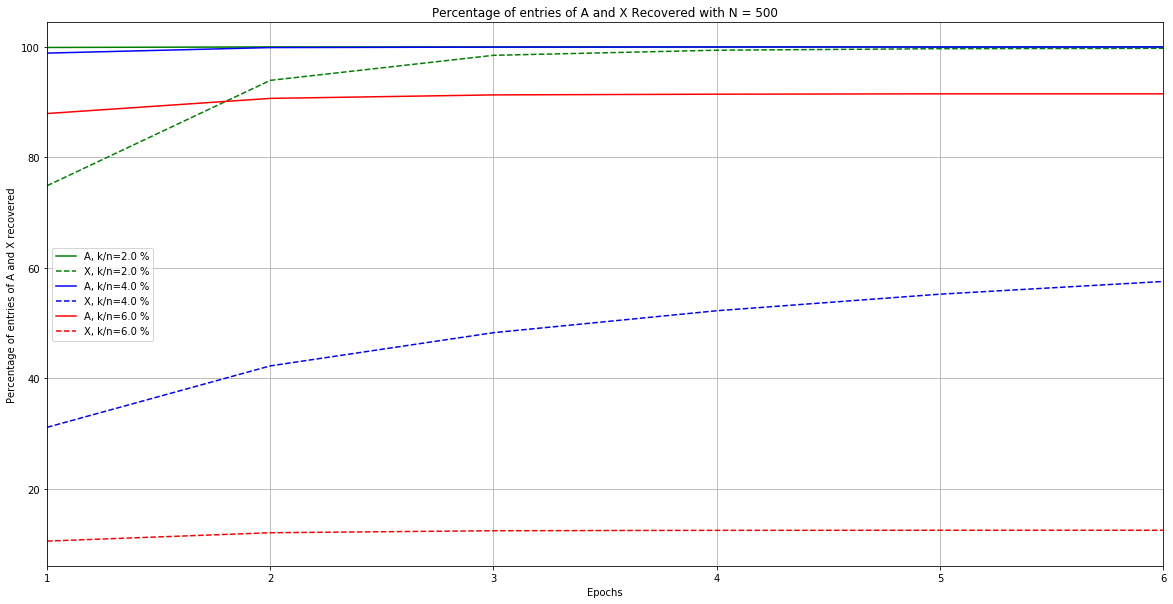

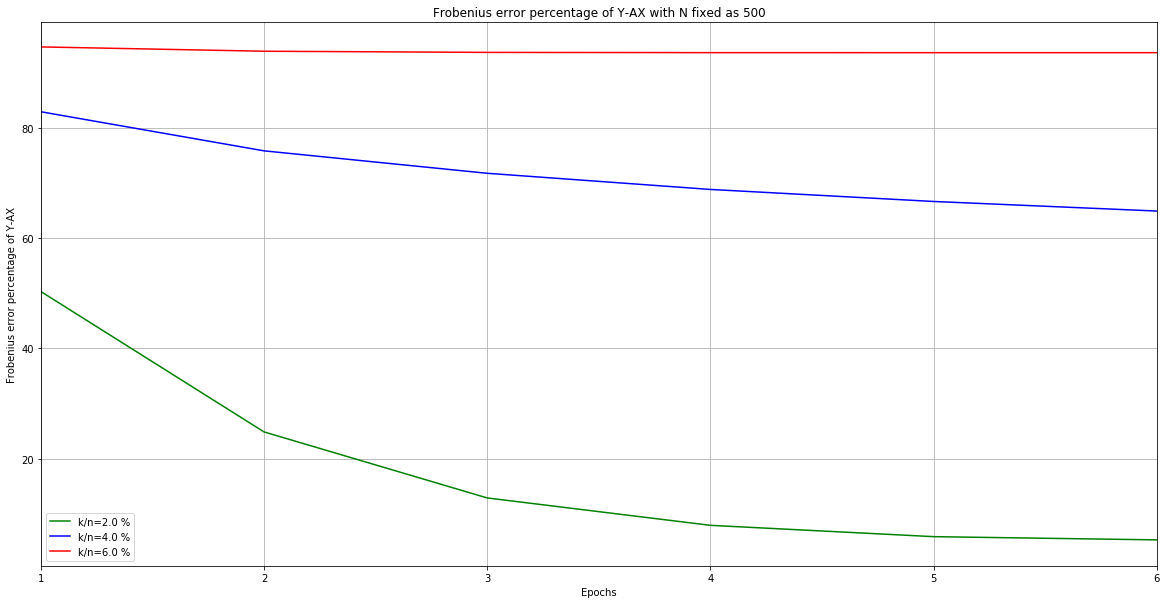

In [127]:
# Plots
plt.figure(1).clear()
plt.figure(2).clear()

plot_A_entries = 100*A_entries/A_sparsity
plot_X_entries = np.zeros((len(k), max_epoch))
plot_total_entries = np.zeros((len(k), max_epoch))
plot_frob = np.zeros((len(k), max_epoch))

for j in range(number_k_to_process):
    plot_frob[j,:] = 100*frob_error_series[j,:]/Y_frob[j]
    plot_X_entries[j,:] = 100*X_entries[j,:]/X_sparsity[j]
    plot_total_entries[j,:] = 100*total_entries[j,:]/total_sparsity[j]
plot_epoch = 6

print("Running times:")
print("k/n=%s %%, %s s"%(100*k[0]/n, comp_time[0]))
print("k/n=%s %%, %s s"%(100*k[1]/n, comp_time[1]))      
print("k/n=%s %%, %s s"%(100*k[2]/n, comp_time[2]))     
    
plt.figure(1)
plt.figure(figsize=(20,10))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="A, k/n=%s %%"%(100*k[0]/n))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g--',label="X, k/n=%s %%"%(100*k[0]/n))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="A, k/n=%s %%"%(100*k[1]/n))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b--',label="X, k/n=%s %%"%(100*k[1]/n))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="A, k/n=%s %%"%(100*k[2]/n))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r--',label="X, k/n=%s %%"%(100*k[2]/n))
plt.grid(True)
plt.title('Percentage of entries of A and X Recovered with N = %s'%(N))
plt.xlabel('Epochs')
plt.ylabel('Percentage of entries of A and X recovered')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures/A_X_recovery.eps', format='eps', bbox_inches='tight')

plt.figure(2)
plt.figure(figsize=(20,10))
plt.plot(np.arange(max_epoch)+1, plot_frob[0], 'g-', label="k/n=%s %%"%(100*k[0]/n))
plt.plot(np.arange(max_epoch)+1, plot_frob[1], 'b-', label="k/n=%s %%"%(100*k[1]/n))
plt.plot(np.arange(max_epoch)+1, plot_frob[2], 'r-', label="k/n=%s %%"%(100*k[2]/n))
plt.title('Frobenius error percentage of Y-AX with N fixed as %s'%(N))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Frobenius error percentage of Y-AX')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures/frob_error.eps', format='eps', bbox_inches='tight')

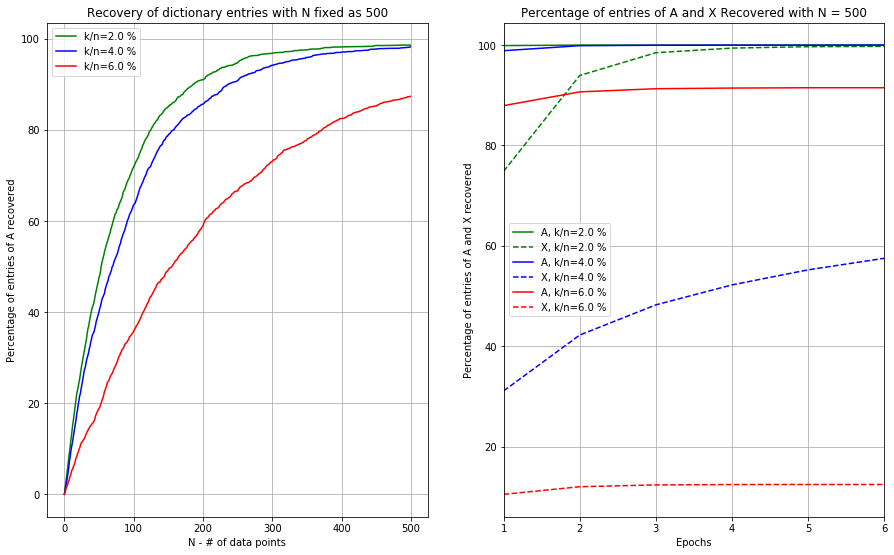

In [144]:
plt.figure(1)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(range(N), plot_per1[0], 'g', label="k/n=%s %%"%(100*k[0]/n))
plt.plot(range(N), plot_per1[1], 'b', label="k/n=%s %%"%(100*k[1]/n))
plt.plot(range(N), plot_per1[2], 'r', label="k/n=%s %%"%(100*k[2]/n))
plt.grid(True)
plt.title('Recovery of dictionary entries with N fixed as %s'%(N))
plt.xlabel('N - # of data points')
plt.ylabel('Percentage of entries of A recovered')
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="A, k/n=%s %%"%(100*k[0]/n))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g--',label="X, k/n=%s %%"%(100*k[0]/n))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="A, k/n=%s %%"%(100*k[1]/n))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b--',label="X, k/n=%s %%"%(100*k[1]/n))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="A, k/n=%s %%"%(100*k[2]/n))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r--',label="X, k/n=%s %%"%(100*k[2]/n))
plt.grid(True)
plt.title('Percentage of entries of A and X Recovered with N = %s'%(N))
plt.xlabel('Epochs')
plt.ylabel('Percentage of entries of A and X recovered')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures/both.eps', format='eps', bbox_inches='tight')

### Remarks
1) Firstly we note that the for loop on line 32 can be trivially parallelized so that the extraction of partial supports from each column can be done simultaneously. This should result in a very significant speedup over the current serial implementation, particularly in the case when $N$ is large.<br>
2) Secondly we will often observe that $A$ is learnt far quicker than $X$, indeed we learn an X value as a by-product of extracting or finding a partial support. Once A has been recovered it still requires multiple epochs to pass through and decode the data points.<br>
3) Sometimes certain entries in $X$ will not be recovered by the algorithm, i.e. a certain number of entries will be missing from the recovery. This is as a result of the columns of $A$ whose indices are in the support of a given column of $X$ overlapping too much, and not satisfyign the unique neighbour property. Although our check ensures that no two columns overlap by more than $2 \epsilon d$, it may be the case that a set of $l \geq 3$ columns of $A$ overlap enough that partial support can be extracted.<br>
